In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import os
import sys
import math
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib import cm, colors
import copy
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.progress import *
%matplotlib inline
palette = sns.color_palette("bright", 10)

In [2]:
n=2000
sampled_df1=pd.read_csv("final_2000.csv")
df_X=sampled_df1.loc[:, sampled_df1.columns.str.contains('X')]

In [3]:
n=2000

In [4]:
df_X.head()

,X2009.07.24,X2009.07.25,X2009.07.26,X2009.07.27,X2009.07.28,X2009.07.29,X2009.07.30,X2009.07.31,X2009.08.01,X2009.08.02,...,X2009.12.11,X2009.12.12,X2009.12.13,X2009.12.14,X2009.12.15,X2009.12.16,X2009.12.17,X2009.12.18,X2009.12.19,X2009.12.20
0,12.710,14.842,12.926,15.661,11.760,14.954,13.673,16.115,13.931,13.338,...,11.604,12.666,13.026,12.147,11.972,10.271,14.113,10.563,13.244,14.215
1,13.000,9.830,12.840,13.590,10.100,13.020,16.450,10.410,16.990,8.690,...,35.250,32.220,22.190,28.840,27.470,31.080,27.030,29.660,35.020,30.310
2,4.917,7.580,3.755,5.276,4.290,4.854,4.774,4.190,5.406,6.408,...,4.358,4.778,5.941,5.293,4.938,4.026,4.654,4.320,4.953,8.196
3,14.150,11.850,19.620,14.180,11.220,19.550,14.230,9.140,3.070,3.090,...,30.310,23.220,24.750,33.930,18.050,10.730,19.970,14.760,18.200,19.170
4,6.034,4.943,4.877,5.264,6.106,6.453,6.313,5.306,5.529,5.670,...,15.866,12.517,11.832,15.673,11.952,11.061,11.152,11.127,12.099,10.338


In [5]:
k0=30
k=9
kmeans = KMeans(n_clusters=k0, random_state=0).fit(df_X)

In [6]:
cluster_centers=pd.DataFrame(kmeans.cluster_centers_,columns=df_X.columns, index=["center"+str(i) for i in range(k0)])
frames = [df_X, cluster_centers]
df_X_1 = pd.concat(frames)
dfij=pd.DataFrame(distance_matrix(df_X_1.values, df_X_1.values), index=df_X_1.index, columns=df_X_1.index)
dij=dfij.to_numpy()
dij = np.round(dij, decimals=2)

In [7]:
colors = sns.color_palette()
c1, c2, c3, c4, c5, c6,c7,c8,c9,c10 = colors[0], colors[1], colors[2], colors[3], colors[4], colors[5],colors[6],colors[7],colors[8],colors[9]

In [8]:
def label_transform(x):
    if x in (1, 2, 3):
        return 'H'
    if x in (52, 53, 54):
        return 'L'
    return 'O'

In [9]:
def label_to_color(x):
    if x in (1,2,3):
        return c4
    if x in (52,53,54):
        return c1
    return c5

In [10]:
def label_to_alphas(x):
    if x in (1,2,3):
        return 1
    if x in (52,53,54):
        return 1
    return 0.4

In [12]:
sampled_df1['acorn_label'] = sampled_df1['ACORN_Type'].apply(lambda x:label_transform(x))

In [13]:
H=sampled_df1[sampled_df1['label']=='H'].index
L=sampled_df1[sampled_df1['label']=='L'].index
O=sampled_df1[sampled_df1['label']=='O'].index

In [14]:
def find_most_closed_points(dij,k0):
    N=dij.shape[0]
    min_index=[]
    for i in range(N-k0,N):
        mini_value=math.inf
        for j in range(N-k0):
            if dij[i,j]<mini_value:
                mini_value=dij[i,j]
                mini_index=j
        min_index.append(mini_index)
    return min_index

In [15]:
M=range(len(set(find_most_closed_points(dij,k0))))
N=range(sampled_df1.shape[0])
column1=list(set(find_most_closed_points(dij,k0)))

In [16]:
ddfij=dfij.iloc[0:n,column1]
ddfij=ddfij.to_numpy()
ddfij = np.round(ddfij, decimals=2)

In [122]:
def init_lambdas(N,M,lambda0,ddfij):
    lambdas=np.zeros(shape=(len(N),len(M)))
    mini_list=[]
    for i in N:
        mini_value=math.inf
        for j in M:
            if ddfij[i,j]<mini_value:
                mini_value=ddfij[i,j]
        mini_list.append(mini_value)
    for i in N:
        for j in M:
            if ddfij[i,j]==mini_list[i]:
                lambdas[i,j]=mini_list[i]
    return lambdas

In [119]:
lambdas,mini_list=init_lambdas(N=N,M=M,lambda0=50, ddfij=ddfij)

In [93]:
def model_zx(name, lambdas, N, M, H, L, ddfij):
    mdl=Model(name=name)
    #set variables
    x=mdl.continuous_var_dict([(i,j) for i in N for j in M],lb=0.0, name="x")
    mdl.add_constraints(mdl.sum(x[i, j] for j in M) == 1 for i in N)
    mdl.add_constraints(x[i1, j]+x[i2, j] -1<= 0 for i1 in H for i2 in L for j in M)
    
    mdl.minimize(mdl.sum((ddfij[i, j]+lambdas[i,j])*x[i,j] for i in N for j in M))
    
    sol_model = mdl.solve(clean_before_solve=True)
    #print("model_LR_x solved!")
    obj_zx=sol_model.get_objective_value()
    zx_X=np.zeros(shape=(ddfij.shape[0],ddfij.shape[1]))
    for i in N:
        for j in M:
            zx_X[i,j]=x[(i,j)].solution_value
    
    return obj_zx, zx_X

In [94]:
def model_zy(name,M,lambdas,k):
    mdl=Model(name=name)
    #set variables
    y=mdl.binary_var_dict([j for j in M],name="y")
    mdl.add_constraint(mdl.sum(y[j] for j in M) ==k)  
    lambda_row_sum=lambdas.sum(axis=0)
    mdl.maximize(mdl.sum(lambda_row_sum[j]*y[j] for j in M))
    sol_model = mdl.solve(clean_before_solve=True)
    #print("model_LR_y solved!")
    obj_zy=sol_model.get_objective_value()
    zy_Y=np.zeros(shape=(ddfij.shape[1]))
    for j in M:
        zy_Y[j]=y[j].solution_value
    return obj_zy, zy_Y

In [95]:
def feasible_solution(name, N, M, H, L, ddfij, k, zy_Y):
    mdl=Model(name=name)
    #set variables

    x=mdl.continuous_var_dict([(i,j) for i in N for j in M],lb=0.0, name="x")
    
    mdl.add_constraints(x[i, j] -zy_Y[j]<= 0 for i in N for j in M)
    mdl.add_constraints(mdl.sum(x[i, j] for j in M) == 1 for i in N)
    mdl.add_constraints(x[i1, j]+x[i2, j] -1<= 0 for i1 in H for i2 in L for j in M)
    
    mdl.minimize(mdl.sum(ddfij[i, j]*x[i,j] for i in N for j in M))
    
    sol_model = mdl.solve(clean_before_solve=True)
    #print("model_feasible_solution solved!")
    z_UB=sol_model.get_objective_value()
    z_UB_X=np.zeros(shape=(ddfij.shape[0],ddfij.shape[1]))
    for i in N:
        for j in M:
            z_UB_X[i,j]=x[(i,j)].solution_value
    
    return z_UB, z_UB_X, zy_Y

In [96]:
def subgradient_iteration(lambdas, subgradient, z_UB, z_LR,  epsilon, beta):    
    if np.linalg.norm(subgradient)<0.002:
        return lambdas
    alpha = beta * ( z_UB - z_LR )/(np.square(subgradient).sum())
    print(f"alpha:{alpha}")
    print(f"subgradient^2:{np.square(subgradient).sum()}")
    #print(alpha)
    for i in range(lambdas.shape[0]):
        for j in range(lambdas.shape[1]):
            if (np.abs(subgradient[i,j])>epsilon):                
                lambdas[i,j] = max(lambdas[i,j] + alpha * subgradient[i,j], 0)
    #print(f"subgradient: {subgradient}, step: {subgradient*alpha}, lambdas: {lambdas}")
    return lambdas

In [97]:
def xij_to_label(U_Xij):
    labels=[]
    for i in N:
        for j in M:
            if U_Xij[i,j]!=0:
                labels.append(j)
    return labels

In [123]:
def solve_lagrangian_dual(N,M,H,L,O, ddfij,k,epsilon,beta,iterations,lambda0):
    z_LB=np.full(iterations+1, -np.inf)
    z_LR=np.zeros(iterations+1)
    z_UB=np.full(iterations+1, np.inf)
    z_FB=np.zeros(iterations+1)
    lambdas=init_lambdas(N,M,lambda0,ddfij)
    _lambdas = [lambdas]
    labels_list=[]
    Y_list=[]
    time1=[]
    start11=datetime.now()
    #name, lambdas, N, M, H, L, ddfij
    obj_zy, zy_Y=model_zy("model_LR_y",M,lambdas,k)
    #name,M,lambdas,k
    obj_zx, zx_X=model_zx("model_LR_x", lambdas, N,M,H,L, ddfij)

    z_LR[0]=obj_zx-obj_zy
    print(f"obj_zy:{obj_zy}, obj_zx:{obj_zx}")
    z_LB[0]=z_LR[0]
    #(name, N, M, H, L, ddfij, k, zy_Y)
    z_UB[0],X, Y =feasible_solution("Feasible",N, M,H,L,ddfij, k, zy_Y)
    z_FB[0]=z_UB[0]
    subgradient = zx_X-zy_Y
    timerecord=datetime.now()-start11
    time1.append(timerecord) 
    
    for t in range(iterations):
        start11=datetime.now()
        lambdas=subgradient_iteration(lambdas, subgradient, z_FB[t], z_LR[t], epsilon, beta)
        
        obj_zy, zy_Y=model_zy("model_LR_y",M,lambdas,k)
        obj_zx, zx_X=model_zx("model_LR_x", lambdas, N,M,H,L, ddfij)
        z_LR[t+1]=obj_zx-obj_zy
        print(f"obj_zy:{obj_zy}, obj_zx:{obj_zx}")
        z_LB[t+1] = max( z_LB[t], z_LR[t+1])
        #(name, N, M, H, L, ddfij, k, zy_Y)
        z_UB[t+1], z_UB_X, zy_Y=feasible_solution("Feasible", N, M,H,L,ddfij, k, zy_Y)
        labels=xij_to_label(z_UB_X)

        z_FB[t+1] = min(z_FB[t],z_UB[t+1])
        subgradient=zx_X-zy_Y
        _lambdas.append(lambdas.copy())
        if t % math.ceil(iterations/2) == 0:
            beta=beta/2
        if t % math.ceil(iterations/3) == 0:
            beta=beta/3
        timerecord=datetime.now()-start11
        time1.append(timerecord)
        labels=xij_to_label(z_UB_X)
        labels_list.append(labels)
        #pd.DataFrame(L_Xij).to_csv('L_Xij' + str(t) + '.csv')
        #pd.DataFrame(U_Xij).to_csv('U_Xij' + str(t) + '.csv')
        #pd.DataFrame(zy_Y).to_csv('L_111Yj' + str(t) + '.csv')
        Y_list.append(zy_Y)
        
        print(t)
        print(f"z_FB_best:{z_FB[t]}") 
        print(f"z_LR_best:{z_LR[t]}")
    

    return z_FB[:iterations],z_UB[:iterations],z_LB[:iterations],z_LR[:iterations],_lambdas,time1,labels_list,labels,Y_list

In [124]:
start2=datetime.now()
z_FB, z_UB, z_LB,z_LR,_lambdas,time1,labels_list,labels,Y_list=solve_lagrangian_dual(N=N,M=M,H=H,L=L,O=O,ddfij=ddfij,k=k,epsilon=0.1, beta=2,iterations=100,lambda0=100)
print(datetime.now()-start2)

obj_zy:51095.189999999995, obj_zx:93429.60666666664
alpha:6.387735704528337
subgradient^2:17406.444444444445
obj_zy:44945.78685671976, obj_zx:96319.38826667005
0
z_FB_best:97928.3
z_LR_best:42334.41666666665
alpha:0.8560799535888778
subgradient^2:17596.0
obj_zy:43817.559610282624, obj_zx:96916.60262408937
1
z_FB_best:96564.34999999998
z_LR_best:51373.60140995029
alpha:0.8370221870750151
subgradient^2:17202.0
obj_zy:43115.50893055899, obj_zx:97326.2825669602
2
z_FB_best:96294.40999999997
z_LR_best:53099.043013806746
alpha:0.7981950432653137
subgradient^2:17574.5
obj_zy:42743.758414498734, obj_zx:97729.07875139208
3
z_FB_best:96294.40999999997
z_LR_best:54210.77363640121
alpha:0.7780808359817413
subgradient^2:17697.0
obj_zy:42190.33337783475, obj_zx:98129.87038942815
4
z_FB_best:96294.40999999997
z_LR_best:54985.32033689335
alpha:0.7697198632106236
subgradient^2:17476.0
obj_zy:41633.83526730258, obj_zx:98394.59256660509
5
z_FB_best:96294.40999999997
z_LR_best:55939.5370115934
alpha:0.744

obj_zy:29378.34206491339, obj_zx:102192.62511560366
52
z_FB_best:95914.53
z_LR_best:72758.46907582405
alpha:0.0737263884966033
subgradient^2:17406.888888888887
obj_zy:29345.70361524852, obj_zx:102190.33572492482
53
z_FB_best:95914.53
z_LR_best:72814.28305069027
alpha:0.0711762031949948
subgradient^2:18006.875
obj_zy:29328.85021300162, obj_zx:102204.65870559492
54
z_FB_best:95914.53
z_LR_best:72844.6321096763
alpha:0.07219408723750385
subgradient^2:17729.0
obj_zy:29271.40597509939, obj_zx:102205.22061350092
55
z_FB_best:95914.53
z_LR_best:72875.80849259329
alpha:0.07125670642282149
subgradient^2:17917.0
obj_zy:29260.651273764124, obj_zx:102217.19750913873
56
z_FB_best:95914.53
z_LR_best:72933.81463840153
alpha:0.07197559563664616
subgradient^2:17720.5
obj_zy:29201.336879906285, obj_zx:102221.61211743162
57
z_FB_best:95914.53
z_LR_best:72956.54623537461
alpha:0.07114098776386346
subgradient^2:17878.625
obj_zy:29201.324092982053, obj_zx:102223.36460177263
58
z_FB_best:95914.53
z_LR_best:7

In [ ]:
pd.DataFrame(labels_list).T.to_csv("k_means_LR_inequa_labels_list.csv")

In [145]:
#output result
iterations=range(1,101)
df_result = pd.DataFrame({'iterations':iterations,'z_LB':z_LB,'z_LR':z_LB ,'z_UB':z_UB,'z_FB':z_FB,'time':time1[0:100]})
df_result.to_csv('k_means_LR_inequality_results.csv')

In [147]:
df_result.tail()

,iterations,z_LB,z_LR,z_UB,z_FB,time
95,96,73807.604166,73807.604166,96394.90,95752.21,0 days 00:00:36.954911
96,97,73819.149764,73819.149764,96454.79,95752.21,0 days 00:00:27.661396
97,98,73827.084116,73827.084116,96797.35,95752.21,0 days 00:00:28.786796
98,99,73836.254486,73836.254486,96430.24,95752.21,0 days 00:00:26.699035
99,100,73853.030061,73853.030061,96214.43,95752.21,0 days 00:00:26.389437


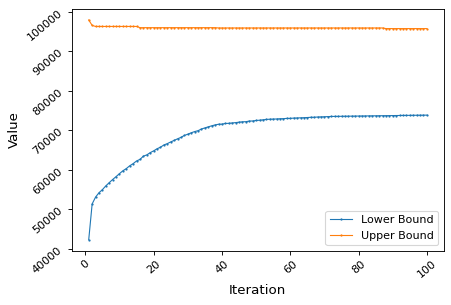

In [150]:
#plot UB and LB
ax = plt.figure(figsize=(6, 4), dpi=80).add_subplot(111)
ax.plot(df_result['iterations'], df_result['z_LR'], linewidth = 1,marker='o',markersize=1,label="Lower Bound")
ax.plot(df_result['iterations'], df_result['z_FB'], linewidth = 1,marker='o',markersize=1,label="Upper Bound")
#ticklabels = ['Monday','Tuesday','Thursday','Wednesday','Friday','Saturday','Sunday']
#ax.set_xticks(np.arange(0,7))
#ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis
ax.tick_params(labelrotation=40)
ax.legend( loc = 'best',prop={ 'size':10})
#ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.
#plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Iteration',fontdict={'size':12})
plt.ylabel('Value',fontsize=12)
plt.show()

In [140]:
sampled_df2=copy.deepcopy(sampled_df1)
sampled_df2['color'] = sampled_df2['ACORN_Type'].apply(lambda x:label_to_color(x))
sampled_df2['plot'] = sampled_df2['ACORN_Type'].apply(lambda x:label_transform(x))
sampled_df2['alphas'] = sampled_df2['ACORN_Type'].apply(lambda x:label_to_alphas(x))
sampled_df2['label']=labels
kmeans_LR_inequ_sampled_df2=sampled_df2.loc[:, sampled_df2.columns.str.contains('X') |sampled_df2.columns.str.contains('label') |sampled_df2.columns.str.contains('ACORN_Type')]
kmeans_LR_inequ_sampled_df2.head()

,X2009.07.24,X2009.07.25,X2009.07.26,X2009.07.27,X2009.07.28,X2009.07.29,X2009.07.30,X2009.07.31,X2009.08.01,X2009.08.02,...,X2009.12.13,X2009.12.14,X2009.12.15,X2009.12.16,X2009.12.17,X2009.12.18,X2009.12.19,X2009.12.20,ACORN_Type,label
0,12.710,14.842,12.926,15.661,11.760,14.954,13.673,16.115,13.931,13.338,...,13.026,12.147,11.972,10.271,14.113,10.563,13.244,14.215,44,1
1,13.000,9.830,12.840,13.590,10.100,13.020,16.450,10.410,16.990,8.690,...,22.190,28.840,27.470,31.080,27.030,29.660,35.020,30.310,5,28
2,4.917,7.580,3.755,5.276,4.290,4.854,4.774,4.190,5.406,6.408,...,5.941,5.293,4.938,4.026,4.654,4.320,4.953,8.196,19,3
3,14.150,11.850,19.620,14.180,11.220,19.550,14.230,9.140,3.070,3.090,...,24.750,33.930,18.050,10.730,19.970,14.760,18.200,19.170,2,28
4,6.034,4.943,4.877,5.264,6.106,6.453,6.313,5.306,5.529,5.670,...,11.832,15.673,11.952,11.061,11.152,11.127,12.099,10.338,1,22


In [142]:
colors=sampled_df2['color']
alphas=sampled_df2['alphas']
plots=sampled_df2['plot']

In [139]:
sampled_df2['label'].value_counts().to_csv('k_means_LR_inequality_2000_9_value_count.csv')
pd.crosstab(kmeans_sampled_df2['label'],kmeans_sampled_df2['ACORN_Type']).to_csv('label_ACORN2000_9_k_means_LR_equality.csv')

In [ ]:
#compute group mean


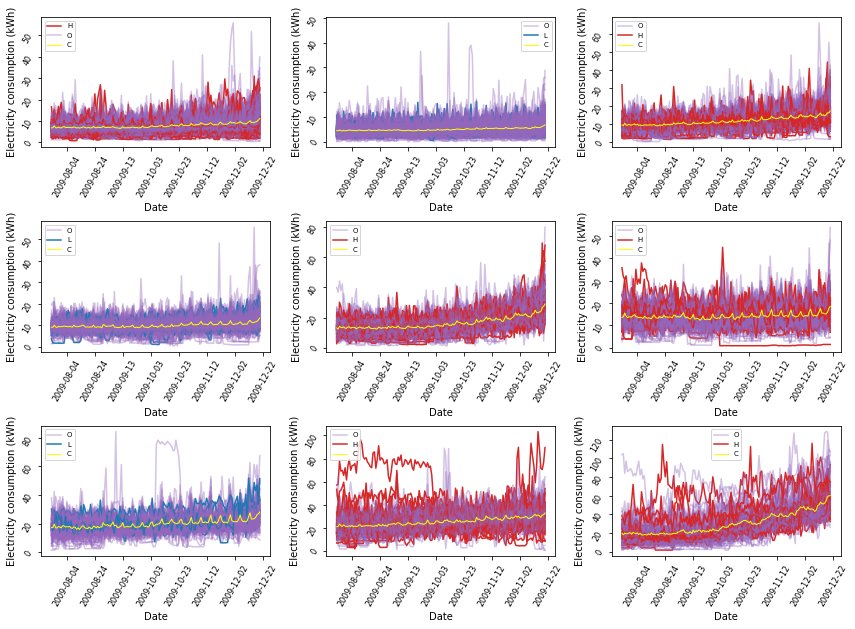

In [143]:
dat_L=kmeans_LR_inequ_sampled_df2
ALL_ACORN_Type=set(kmeans_LR_inequ_sampled_df2['ACORN_Type'].value_counts().values)
labels=kmeans_LR_inequ_sampled_df2['label'].value_counts().index.tolist()
titles=['Pattern 1','Pattern 2','Pattern 3','Pattern 4','Pattern 5','Pattern 6','Pattern 7','Pattern 8','Pattern 9']
y_mean=[]
#fig, ax = plt.subplots(nrows=3, ncols=2)
#fig.set_size_inches(20,15)
#norm = colors.Normalize(vmin=min(ALL_ACORN_Type), vmax=max(ALL_ACORN_Type))
#mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)

fig = plt.figure()
fig.set_size_inches(12,9)
for c,num in zip(labels, range(1,10)):
    df0=dat_L[dat_L['label']==c]
    df0T=df0.drop('label',axis=1).T
    ACORN_Type=df0T.loc['ACORN_Type',:].values
    df0T=df0T.drop('ACORN_Type',axis=0)
    df0T.index=pd.date_range(start='7/24/2009', end='12/20/2009')
    col=df0T.shape[1]
    df0T['Mean']=df0T.mean(axis=1)
    df0T['Date']=pd.to_datetime(df0T.index,infer_datetime_format=True)
    ax = fig.add_subplot(3,3,num)
    for i in range(col):
        #ax.plot(df0T['Date'], df0T.iloc[:,i],color=mapper.to_rgba(ACORN_Type[i]))
        ax.plot(df0T['Date'], df0T.iloc[:,i],color=colors[df0T.columns[i]],alpha=alphas[df0T.columns[i]],label=plots[df0T.columns[i]])
    ax.plot(df0T['Date'], df0T['Mean'],color='yellow',linewidth=1,label='C')
    y_mean.append(df0T['Mean'].mean())
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #my_y_ticks = np.arange(0, 130, 20)
    #plt.yticks(my_y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #ax.set_ylim(0,80)
    #ax.set_title(titles[c-1])
    ax.tick_params(labelrotation=60)
    plt.ylabel('Electricity consumption (kWh)')
    plt.xlabel('Date')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),prop={'size': 7})
    #ax.legend(loc = 'best')

# plt.xlabel('Date')
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
#plt.ylabel('Electricity consumption(KWh)')

#fig.suptitle('Residential daily electricity patterns based on Partitioning Around Medoids algorithms (k=5)',fontsize=25)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()